In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data
data=pd.read_csv('/vol/home/s2465922/data/crime_from_2001.csv')

/vol/home/s2465922/miniconda3/envs/dl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# extract the crime incidents of recent 6 year
df=data[data.Year>2014]

# extract needed columns
df=df[['Date','IUCR', 'Location Description','Community Area']]

# remove rows that has nan values
df=df.dropna(how='any')

# convert time string to datetime type
df['Date']=pd.to_datetime(df['Date'],format='%m/%d/%Y %I:%M:%S %p')

# convert community area as str type
df['Community Area']=df['Community Area'].astype(int).astype(str)

# extract hour
df['hour']=df['Date'].dt.hour

In [9]:
# read criminal IUCR codes
iucr=pd.read_csv('/vol/home/s2465922/data/crime_iucr.csv')
iucr['IUCR']=iucr['IUCR'].apply(lambda s: '0'+s if len(s)<4 else s)

In [10]:
# add primary and secondary description based on matched IUCR code
df=df.set_index('IUCR')
iucr=iucr.set_index('IUCR')
df['primary_type']=iucr['PRIMARY DESCRIPTION']
df['secondary_description']=iucr['SECONDARY DESCRIPTION']
df=df.reset_index()

In [11]:
# %%
# remove punctuations, tokenize, generate texts 

class Processor:
  def __init__(self):
    self.puncs='[+/,.;:?!()]+'
    self.min_word_df=50
    self.min_num_words=3
  
  def make_text(self, df):
    df['text']=df[['primary_type','secondary_description','Location Description']].values.tolist()
    return df
  
  def get_word2inc(self,df):
    '''
    return {word: document frequency}
    '''
    word2inc={}
    inc2text=df['text'].to_dict()
    for i in inc2text:
      for w in inc2text[i]:
        if w in word2inc:
          word2inc[w].add(i)
        else:
          word2inc[w]={i}
    return word2inc
  
  def clean_word(self,df):
    '''
    delete words that occur less than min_word_df
    '''
    word2inc=self.get_word2inc(df)
    
    # modify dataframe
    for w in word2inc:
      if len(word2inc[w])<=self.min_word_df:
        for i in word2inc[w]:
          df['text'][i].remove(w)
    return df
  
  def clean_data(self,df):
    '''
    delete examples where number of keywords less than min_num_words
    '''
    tmp=pd.DataFrame(df['text'].apply(len))
    tmp.columns=['numWords']
    deleted=tmp[tmp['numWords']<self.min_num_words].index.tolist()
    df=df.drop(deleted)
    return df

In [12]:
cdf=df.copy()
ps=Processor()
cdf=ps.make_text(cdf)
cdf=ps.clean_word(cdf)
cdf=ps.clean_data(cdf)

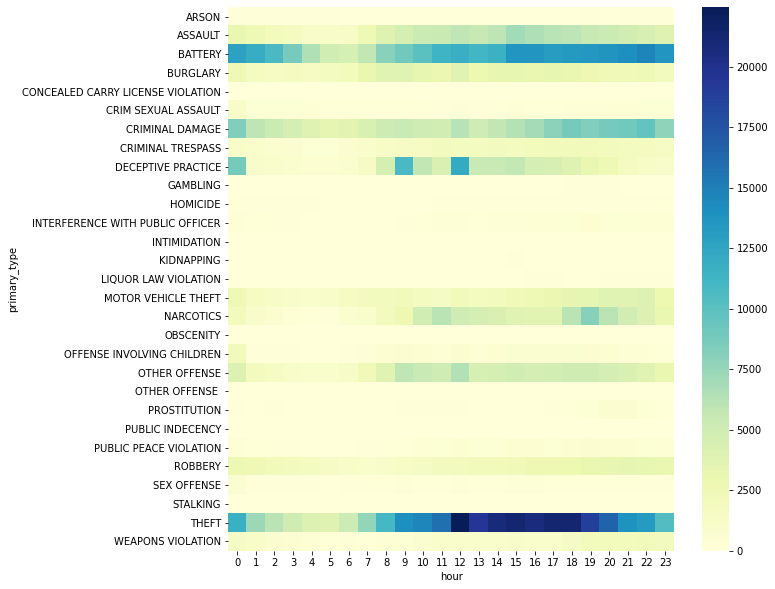

In [18]:
cdf_hour=cdf.groupby(by=['hour','primary_type']).size().reset_index()
cdf_hour.columns=['hour','primary_type','count']
cdf_hour=cdf_hour.pivot_table(index="primary_type",columns="hour",values="count").fillna(0)

plt.figure(figsize=(10,10))
ax=sns.heatmap(cdf_hour,cmap="YlGnBu")
plt.show()

In [19]:
import geopandas as gpd
import numpy as np

shp="/vol/home/s2465922/data/community_areas/geo_export_2d6ca2cd-726e-4f78-9dc4-b833b8f52d77.shp"

community=gpd.read_file(shp)

In [26]:
community.columns

Index(['area', 'area_num_1', 'area_numbe', 'comarea', 'comarea_id',
       'community', 'perimeter', 'shape_area', 'shape_len', 'geometry'],
      dtype='object')

In [28]:
cdf_area=cdf.groupby(by=['Community Area', 'primary_type']).size().reset_index()
cdf_area.columns=['community_area','primary_type','count']
cdf_area=cdf_area.set_index('community_area')

In [30]:
cdf_area

,primary_type,count
community_area,,
1,ARSON,12
1,ASSAULT,1385
1,BATTERY,3817
1,BURGLARY,920
1,CRIM SEXUAL ASSAULT,165
...,...,...
9,ROBBERY,10
9,SEX OFFENSE,7
9,STALKING,1


In [36]:
cdf_theft=pd.DataFrame(cdf_area.loc[cdf_area.primary_type=='THEFT','count'])

In [27]:
community=community.set_index('area_num_1')

In [38]:
community['theft_count']=cdf_theft['count']

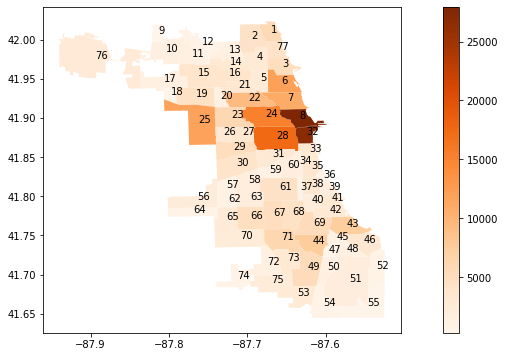

In [52]:
community=community.reset_index()
community.plot(column='theft_count',
               legend=True,
               cmap='Oranges',
               figsize=(15, 6))

for i, geo in community.centroid.iteritems():
  plt.annotate(s=community['area_num_1'][i],xy=[geo.x,geo.y])

In [51]:
community.centroid

0     POINT (-87.61868 41.83512)
1     POINT (-87.60322 41.82375)
2     POINT (-87.63242 41.80909)
3     POINT (-87.61786 41.81295)
4     POINT (-87.59618 41.80892)
                 ...            
72    POINT (-87.71319 41.69488)
73    POINT (-87.66905 41.68973)
74    POINT (-87.89370 41.97568)
75    POINT (-87.66342 41.98671)
76    POINT (-87.81378 42.00761)
Length: 77, dtype: geometry